# COVID REPORTING KOENVS

## Imports

In [64]:
import urllib3
import pandas as pd
import bs4
from pathlib import Path
from json import loads
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math
import numpy as np

mpl.rcParams["figure.figsize"] = 10,8
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.grid.which"] = "both"
mpl.style.use("ggplot_updated.mplstyle")

## Get data from Sciensano

Gets page from Sciensano with data storage links, use bs4 to look for resources ending in JSON and CSV. CSV is more efficient to pull so all datasets are downloaded and converted to pd.DataFrames. At the end, downloaded dataset are shown with columns printed. First data is filtered (remove French and incomplete rows)

In [2]:
http = urllib3.PoolManager()
r = http.request("GET", "https://epistat.wiv-isp.be/covid/")
page = bs4.BeautifulSoup(r.data.decode("utf8"), 'html.parser')
links = list(map(lambda x: x.get("href"), page.find_all("a")))
json_links = []
csv_links = []
for link in links:
    temp = Path(link)
    if temp.suffix == ".json":
        json_links.append((temp.name.rstrip(temp.suffix), link))
    elif temp.suffix == ".csv":
        csv_links.append((temp.name.rstrip(temp.suffix), link))
csv_links
dict_df = {}
p1 = re.compile("fr", re.IGNORECASE)
p2 = re.compile("nr_reporting", re.IGNORECASE)
for x, y in csv_links:
    # pandas has build in url fetching/getting, no need for BS4 in this case
    # no_na = pd.read_json(y).dropna(axis = 0) # 1.4 seconds
    # 700 ms (faster less overhead than json)   
    try:
        no_na = pd.read_csv(y, parse_dates=["DATE"], dayfirst=True, ).dropna(axis=0, how="any")
    except ValueError:
        print(f"{x}: no column with date found")
        no_na = pd.read_csv(y).dropna(axis=0, how="any")
    for e in no_na.columns:
        m1 = re.search(p1, e)
        m2 = re.search(p2, e)
        if m1 or m2:
            no_na.drop(e, axis=1, inplace=True)
    dict_df[x] = no_na.convert_dtypes()
print("-" * 30)
for i, [k, v] in enumerate(dict_df.items()):
    print(f"Dataset {i+1}:\n\tName: {k}\n\tColumns: ", end = "")
    for j, x in enumerate(v):
        if (j+1) != len(v.columns):
            print(f"{x}, ", end = "")
        else:
            print(f"{x}")
    print(f"\tShape: {v.shape}")
print("-" * 30)
popul_BE = pd.read_pickle("population_BE_2020_processed.pkl")
print("Population data loaded from 'population_BE_2020_processed.pkl'")

COVID19BE_CASES_MUNI_CUM: no column with date found
------------------------------
Dataset 1:
	Name: COVID19BE_CASES_AGESEX
	Columns: DATE, PROVINCE, REGION, AGEGROUP, SEX, CASES
	Shape: (47353, 6)
Dataset 2:
	Name: COVID19BE_CASES_MUNI_CUM
	Columns: NIS5, TX_DESCR_NL, TX_ADM_DSTR_DESCR_NL, PROVINCE, REGION, CASES
	Shape: (581, 6)
Dataset 3:
	Name: COVID19BE_CASES_MUNI
	Columns: NIS5, DATE, TX_DESCR_NL, TX_ADM_DSTR_DESCR_NL, PROVINCE, REGION, CASES
	Shape: (87522, 7)
Dataset 4:
	Name: COVID19BE_HOSP
	Columns: DATE, PROVINCE, REGION, TOTAL_IN, TOTAL_IN_ICU, TOTAL_IN_RESP, TOTAL_IN_ECMO, NEW_IN, NEW_OUT
	Shape: (3377, 9)
Dataset 5:
	Name: COVID19BE_MORT
	Columns: DATE, REGION, AGEGROUP, SEX, DEATHS
	Shape: (3888, 5)
Dataset 6:
	Name: COVID19BE_test
	Columns: DATE, PROVINCE, REGION, TESTS_ALL, TESTS_ALL_POS
	Shape: (3531, 5)
------------------------------


## Data in function of age

### Data Processing

In [65]:
grouped = dict_df["COVID19BE_CASES_AGESEX"].groupby(by=["DATE", "AGEGROUP"]).sum()
final = grouped.unstack().CASES.fillna(0)
groups = sorted(dict_df["COVID19BE_CASES_AGESEX"]["AGEGROUP"].unique())

### Plotting

(array(18444.), 18642.0)

<Figure size 864x720 with 0 Axes>

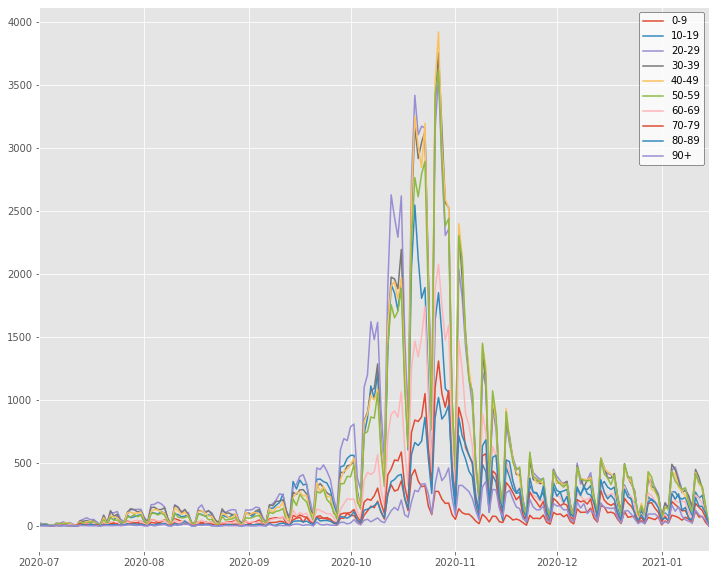

In [66]:
plt.clf()
fig, ax = plt.subplots(1, 1)
for e in groups:
    ax.plot(final[e].index, list(final[e]), label=f"{e}")
ax.legend()
ax.set_xlim(["2020-07-01", final.index[len(final.index)-1]])

(array(18322.), 18642.0)

<Figure size 864x720 with 0 Axes>

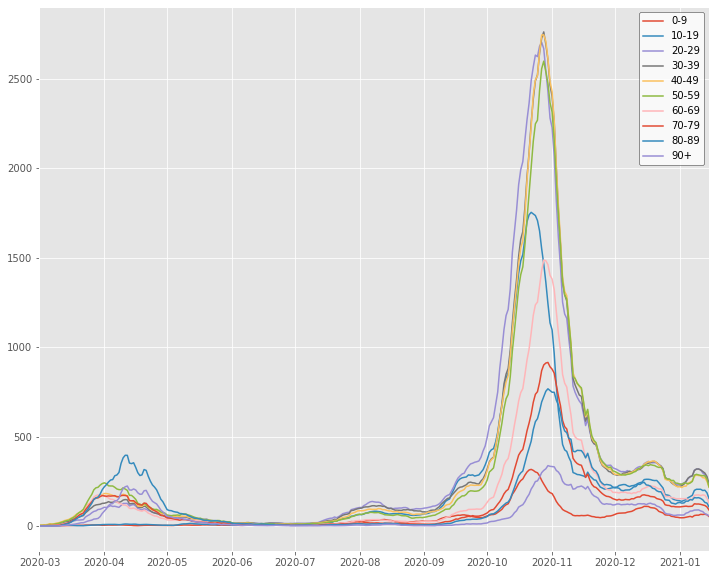

In [84]:
plt.clf()
fig, ax = plt.subplots(1, 1)
for e in groups:
    temp = final[e].rolling(7, min_periods=1).mean()
    temp.apply(int)
    ax.plot(final[e].index, temp, label=f"{e}")
ax.legend()
ax.set_xlim(["2020-03-01", final.index[len(final.index)-1]])

<Figure size 864x720 with 0 Axes>

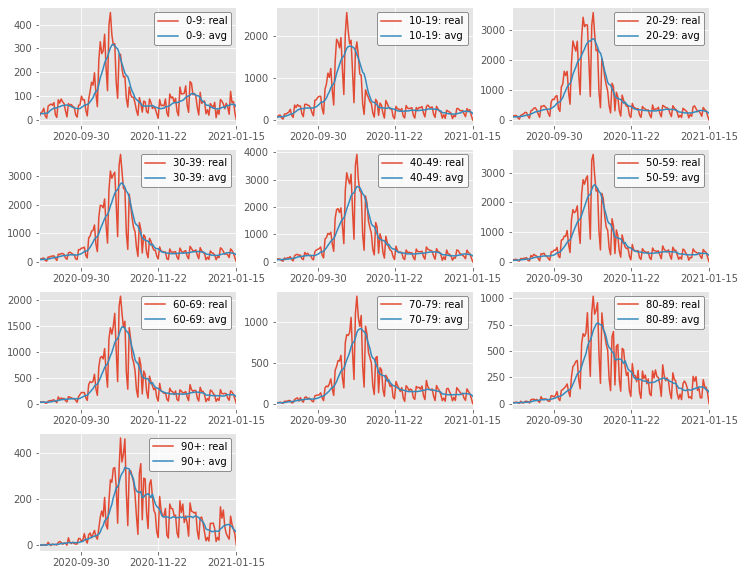

In [68]:
plt.clf()
fig = plt.figure(figsize=(12,10))
num = 6
xt = [final.index[(len(final.index)-1)*x//num] for x in range(1,num+1)]
for i, e in enumerate(groups):
    temp = final[e]
    length = len(groups) + 1
    row = i // (length // 3)
    col = i % 3
    ax = plt.subplot2grid((math.ceil(length/3), 3), (row, col))
    ax.plot(final.index, list(final[e]), label=f"{e}: real")
    ax.plot(final.index, list(final[e].rolling(7, min_periods=1).mean()), label=f"{e}: avg")
    ax.legend()
    ax.set_xticks(xt) # needs to come before limiting with xlim
    ax.set_xlim(["2020-09-01", final.index[len(final.index)-1]])  

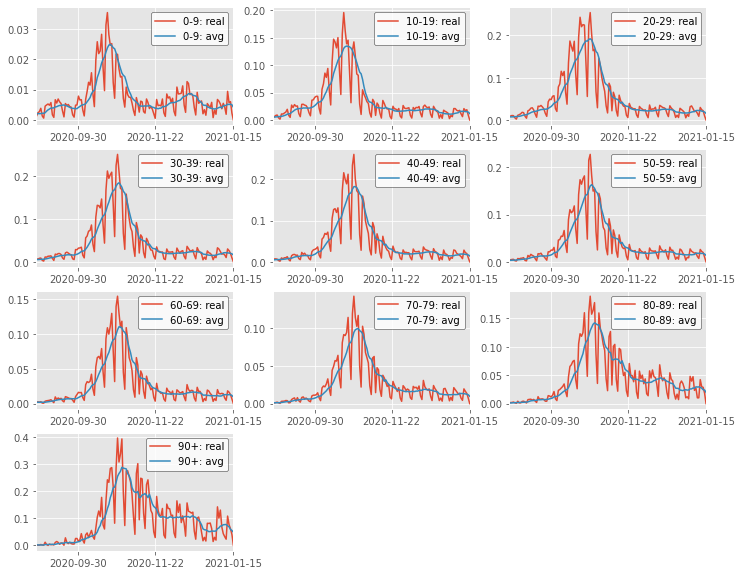

In [69]:
%run pop_functions.py
# USES BELGIAN POPULATION DATA FROM YEAR 2020, RELEASED BY STATBEL
# RECORDED DATE OF THIS NUMBER IS: 1st January 2020
sex_vs_age = popul_BE.pivot_table(index = "sex", columns = ["age"], values = "pop", aggfunc = np.sum)
sex_vs_age.fillna(0, inplace = True)
age_cat = categorize_ages(sex_vs_age)
total_cat = age_cat.apply(np.sum, axis = 0)
final_perc = final.apply(lambda x: x / total_cat * 100, axis = 1)
for i, e in enumerate(groups):
    temp = final_perc[e]
    length = len(groups) + 1
    row = i // (length // 3)
    col = i % 3
    ax = plt.subplot2grid((math.ceil(length/3), 3), (row, col))
    ax.plot(final_perc.index, list(final_perc[e]), label=f"{e}: real")
    ax.plot(final_perc.index, list(final_perc[e].rolling(7, min_periods=1).mean()), label=f"{e}: avg")
    ax.legend()
    ax.set_xticks(xt) # needs to come before limiting with xlim
    ax.set_xlim(["2020-09-01", final_perc.index[len(final_perc.index)-1]]) 

Text(0, 0.5, 'Cumulative sum in percentage of total population (%)')

<Figure size 864x720 with 0 Axes>

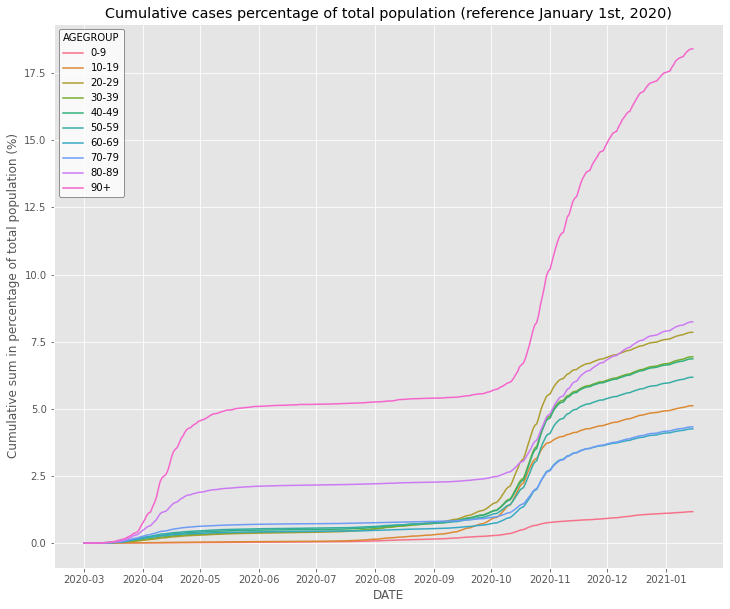

In [99]:
final_cumsum = final.apply(np.cumsum, axis = 0)
sex_vs_age = popul_BE.pivot_table(index = "sex", columns = ["age"], values = "pop", aggfunc = np.sum)
sex_vs_age.fillna(0, inplace = True)
age_cat = categorize_ages(sex_vs_age)
total_cat = age_cat.apply(np.sum, axis = 0)
final_cumsum_perc = final_cumsum.apply(lambda x: x / total_cat * 100, axis = 1)
plt.clf()
fig, ax = plt.subplots()
sns.lineplot(data = final_cumsum_perc, dashes = False, ax = ax)
ax.set_title("Cumulative cases percentage of total population (reference January 1st, 2020)")
ax.set_ylabel("Cumulative sum in percentage of total population (%)")

In [71]:
# SELF MADE "ROLLING" function (deprecated)
def running_avg(col, days):
    cumsum = 0
    res = []
    for i, x in enumerate(col):
        if i == 0:
            res.append(0)
        elif i < days:
            cumsum += x
            res.append(cumsum/i)
        else:
            cumsum += x
            cumsum -= col[i-days]
            res.append(cumsum/days)
    return res

## Data regarding hospitalizations

### Data Processing

In [72]:
hosp = dict_df["COVID19BE_HOSP"].groupby(by="DATE").sum()
diff = hosp.apply(lambda x: x.diff(), axis = 0).fillna(method="bfill")
result = hosp.join(diff, lsuffix="_org", rsuffix="_org_deriv")
result["DATE"] = result.index
result = result.set_index(np.arange(len(result)))
result["TOTAL_IN_avg"] = result.TOTAL_IN_org.rolling(7, min_periods=1).mean().apply(int)
result["TOTAL_IN_avg_deriv"] = result.TOTAL_IN_avg.diff().fillna(method="bfill")
tot_in = result[["DATE", "TOTAL_IN_org", "TOTAL_IN_org_deriv", "TOTAL_IN_avg", "TOTAL_IN_avg_deriv"]]

### Plotting

(array(18444.), 18642.0)

<Figure size 864x720 with 0 Axes>

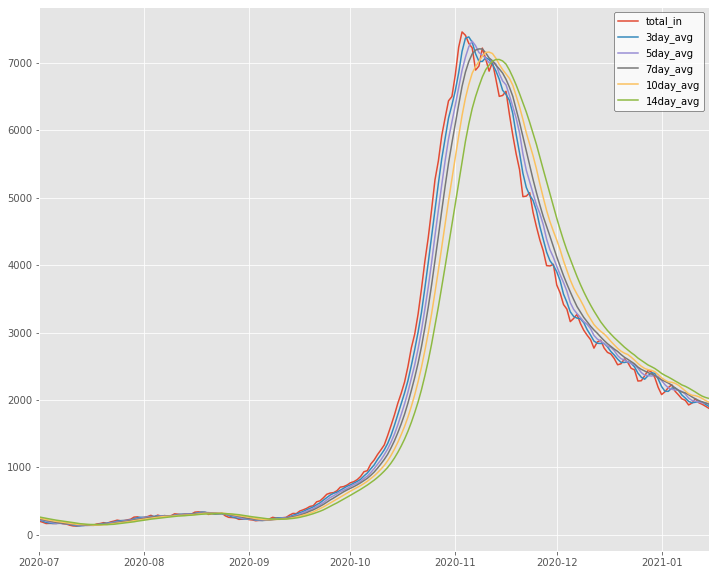

In [73]:
plt.clf()
fig, ax = plt.subplots(1, 1)
ax.plot(hosp.index, list(hosp.TOTAL_IN), label="total_in")
avg_days = [3, 5, 7, 10, 14]
for a in avg_days:
    ax.plot(hosp.index, hosp.TOTAL_IN.rolling(a, min_periods=1).mean().apply(int), label=f"{a}day_avg")
ax.legend()
ax.set_xlim(["2020-07-01", final.index[len(final.index)-1]])

<AxesSubplot:xlabel='DATE'>

<Figure size 864x720 with 0 Axes>

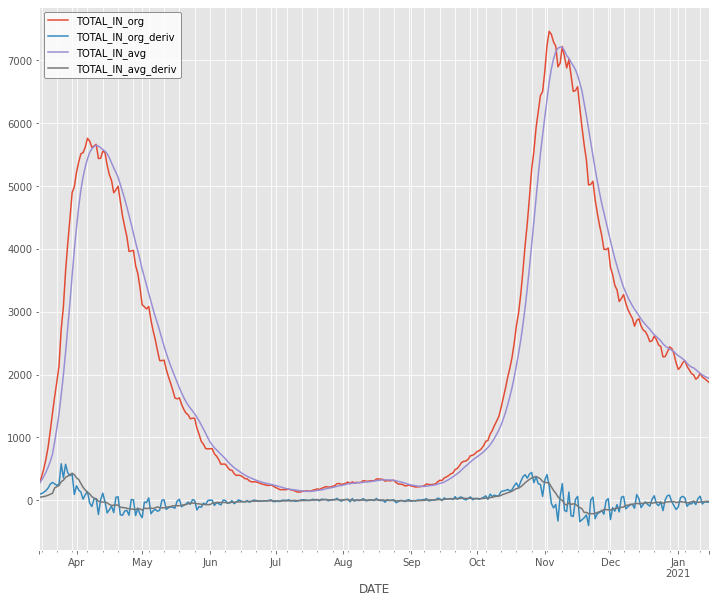

In [74]:
plt.clf()
cols = list(tot_in.columns)
cols.remove("DATE")
tot_in.plot("DATE", cols)
# plt.xlim(["2020-07-01", final.index[len(final.index)-1]])

## Data related to region

### Data processing

In [75]:
temp, cleaned, arr_leuven = None, None, None
temp = dict_df["COVID19BE_CASES_MUNI"]
temp.loc[temp["CASES"] == "<5", "CASES"] = "5"
arr_leuven = temp[temp.TX_ADM_DSTR_DESCR_NL.str.contains("Leuven")]
cleaned = arr_leuven.astype({"CASES": "Int32"})

### Plotting

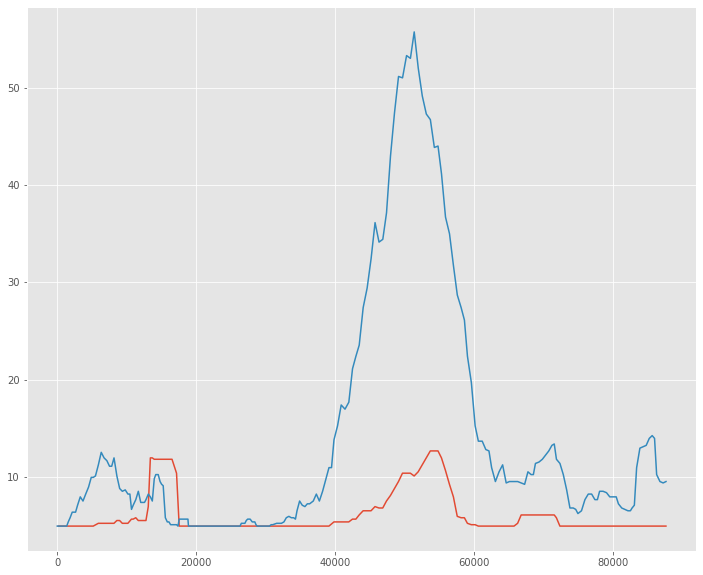

In [76]:
li = ["Herent", "Leuven"]
plt.clf()
# fig, ax = plt.subplots(1, 1)
for x in li:
    temp = cleaned[cleaned.TX_DESCR_NL.str.contains(x)]
    pl = temp.CASES.rolling(7, min_periods=1).mean()
    pl.plot.line()
# ax.legend()

## Data regarding hospitalizations 2

### Data processing

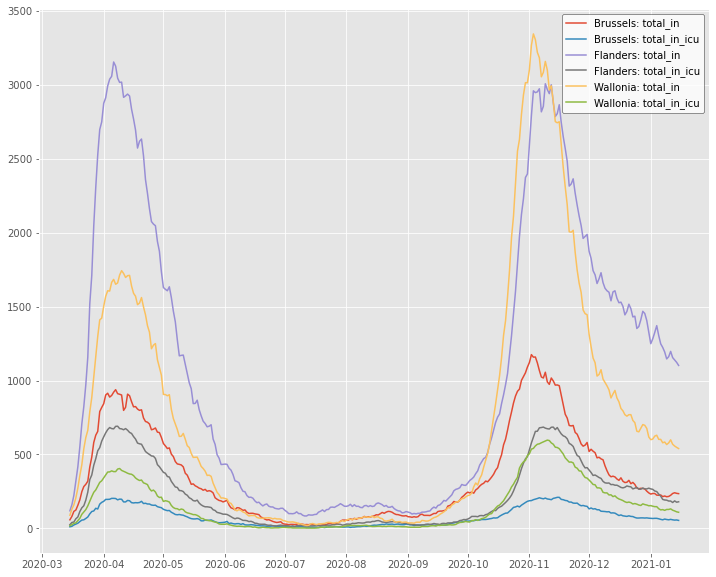

In [77]:
hosp = dict_df["COVID19BE_HOSP"].drop(["PROVINCE"], axis = 1)
summed = hosp.groupby(by=["DATE", "REGION"]).sum()
mult_ind = summed.index.to_frame()
summed["DATE"] = pd.to_datetime(mult_ind.DATE)
summed["REGION"] = mult_ind.REGION.convert_dtypes()
fig, ax = plt.subplots(1, 1)
for e in summed.REGION.unique():
    filtered = summed.filter(like=e, axis = 0)
    ax.plot(filtered.DATE, np.array(filtered.TOTAL_IN), label=f"{e}: total_in")
    ax.plot(filtered.DATE, np.array(filtered.TOTAL_IN_ICU), label=f"{e}: total_in_icu")
ax.legend()

(array(18506.), array([18642.]))

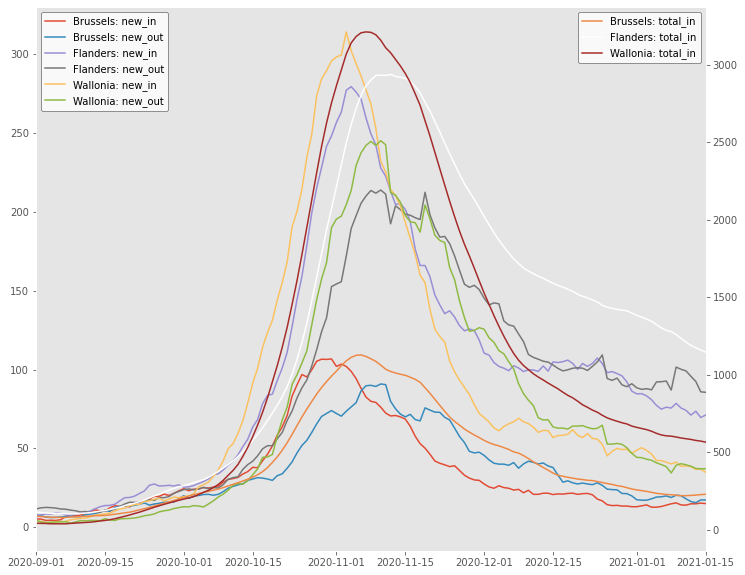

In [83]:
from itertools import cycle
hosp = dict_df["COVID19BE_HOSP"].drop(["PROVINCE"], axis = 1)
summed = hosp.groupby(by=["DATE", "REGION"]).sum()
mult_ind = summed.index.to_frame()
summed["DATE"] = pd.to_datetime(mult_ind.DATE)
summed["REGION"] = mult_ind.REGION.convert_dtypes()
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
colors = cycle(["#EE8845", "white", "brown"])
for e in summed.REGION.unique():
    filtered = summed.filter(like=e, axis = 0)
    # factor = 2 if e == "Flanders" else 3 if e == "Wallonia" else 5 if e = "Brussels" else 7
    ax2.plot(filtered.DATE, filtered.TOTAL_IN.rolling(7, min_periods = 1).mean(), color = next(colors), label=f"{e}: total_in")
    ax.plot(filtered.DATE, filtered.NEW_IN.rolling(7, min_periods = 1).mean(), label=f"{e}: new_in")
    ax.plot(filtered.DATE, filtered.NEW_OUT.rolling(7, min_periods = 1).mean() , label=f"{e}: new_out")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.grid()
ax2.grid()
ax.set_xlim(["2020-09-01", summed.DATE.tail(1)])

In [79]:
%timeit summed[summed.REGION.isin(["Flanders"])] # 600 µs
%timeit filtered = summed.filter(like="Flanders", axis = 0) # 1550 µs

1.68 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18.8 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Testing and positivity

In [87]:
test = dict_df["COVID19BE_test"].copy()
date_reg = test.pivot_table(index = "DATE", columns = "REGION", values = "TESTS_ALL", aggfunc = np.sum)
date_reg_pos = test.pivot_table(index = "DATE", columns = "REGION", values = "TESTS_ALL_POS", aggfunc = np.sum)
date_reg["TOTAL"] = date_reg.apply(sum, axis = 1)
date_reg_pos["TOTAL"] = date_reg_pos.apply(sum, axis = 1)
total_values = date_reg.merge(date_reg_pos, left_index = True, right_index = True, suffixes = ["_all", "_pos"])
total_perc = date_reg_pos/date_reg * 100
for k, v in total_perc.iteritems():
    total_perc[f"{k}_rolling7d"] = v.rolling(7, min_periods = 1).mean()

<Figure size 864x720 with 0 Axes>

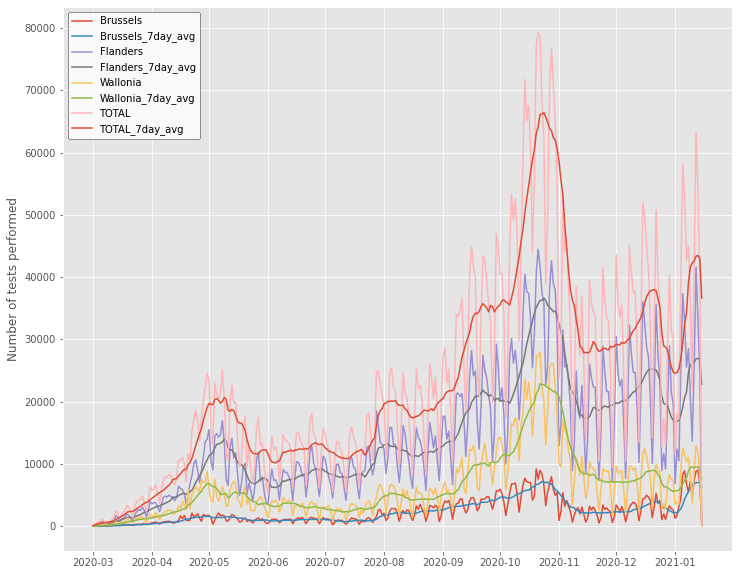

In [125]:
plt.clf()
fig, ax = plt.subplots(1, 1)
for k, v in date_reg.iteritems():
    ax.plot(v.index, v.rolling(1, min_periods = 1).mean(), label = k)
    ax.plot(v.index, v.rolling(7, min_periods = 1).mean(), label = f"{k}_7day_avg")
ax.set_ylabel("Number of tests performed")
ax.legend(loc = "best")

(0.0, 40.0)

<Figure size 864x720 with 0 Axes>

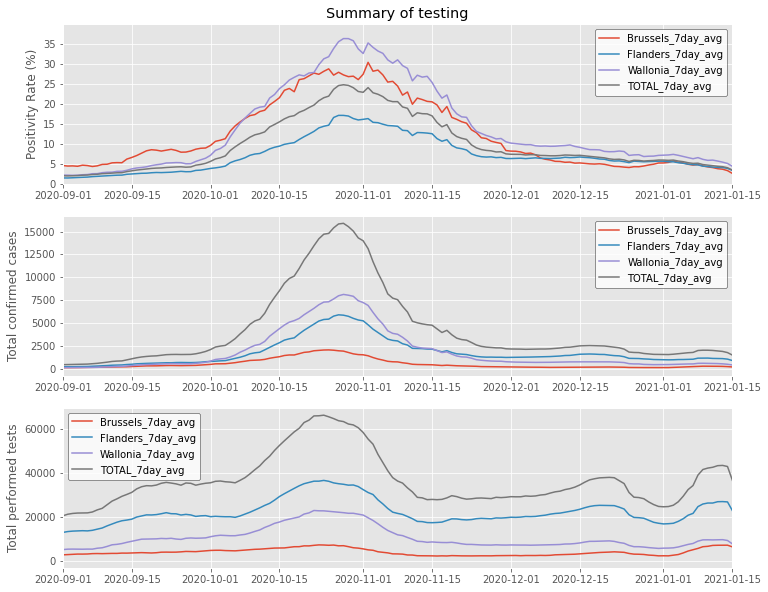

In [142]:
plt.clf()
fig, axs = plt.subplots(3, 1)
def plot_rolling(ax, df):
    for k, v in df.iteritems():
#     ax.plot(v.index, v.rolling(1, min_periods = 1).mean(), label = k)
        ax.plot(v.index, v.rolling(7, min_periods = 1).mean(), label = f"{k}_7day_avg")
reg_cases = dict_df["COVID19BE_CASES_AGESEX"].pivot_table(index = "DATE", columns = ["REGION"], values = "CASES", aggfunc = np.sum).fillna(0)
reg_cases["TOTAL"] = reg_cases.apply(np.sum, axis = 1)
pos_rat = reg_cases / date_reg * 100
axs[0].set_title("Summary of testing")
axs[0].set_ylabel("Positivity Rate (%)")
plot_rolling(axs[0], pos_rat)
axs[1].set_ylabel("Total confirmed cases")
plot_rolling(axs[1], reg_cases)
axs[2].set_ylabel("Total performed tests")
plot_rolling(axs[2], date_reg)
for x in axs:
    x.legend()
    x.set_xlim(["2020-09-01", pos_rat.index[-1]])
axs[0].set_yticks(range(0,40,5))
axs[0].set_ylim([0, 40])